# Making figure 3 of the paper
21/03/2025

In [1]:
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 16})
import json
import os
pipes.plotting.update_rcParams()

# adds in additional chemical evolution models to bagpipes
from code_bits.add_ceh_funcs import *
# adds in VW07 dust to bagpipes
from code_bits.add_VW07_dust import *
# import a bunch of useful functions for interfacing with bagpipes
from code_bits.fitting_MaNGA import *
# adds in additional GP noise kernels to bagpipes
from code_bits.add_GP_SHOTerm import *

Bagpipes: PyMultiNest import failed, fitting will use the Nautilus sampler instead.


In [2]:
# change working directory to one layer above
os.chdir('..')
# set saving direction
save_dir = 'plots/'
# directory of the skyline file
skyline_dir = 'data'
# bagpipes runID, used to find the right folder that holds the 
# posterior samples file
runID_PSB = '8324-12701_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step'
runID_central = '8324-12701_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM'
# file name of the posterior samples file
galID_PSB = '8324-12701_PSBonly_dereddened_051022'
galID_central = '8324-12701_RPSB_centralspx_dereddened_170624'

In [3]:
"""
since the PSB regions' bagpipes fits were ran in an older version of bagpipes, we need
to swap out some parts of bagpipes code on the fly
"""

import deepdish as dd
from copy import deepcopy
import h5py
from bagpipes.fitting import fitted_model,posterior
rank = 0

def fit_init_PSB(self, galaxy, fit_instructions, run=".", time_calls=False,
             n_posterior=500):

    self.run = run
    self.galaxy = galaxy
    self.fit_instructions = deepcopy(fit_instructions)

    # Set up the directory structure for saving outputs.
    if rank == 0:
        utils.make_dirs(run=run)

    # The base name for output files.
    self.fname = "pipes/posterior/" + run + "/" + self.galaxy.ID + "_"

    # A dictionary containing properties of the model to be saved.
    self.results = {"fit_instructions": self.fit_instructions}

    # If a posterior file already exists load it.
    if os.path.exists(self.fname[:-1] + ".h5"):
        self.results = dd.io.load(self.fname[:-1] + ".h5")
        self.posterior = posterior(self.galaxy, run=run,
                                   n_samples=n_posterior)
        self.fit_instructions = dd.io.load(self.fname[:-1] + ".h5",
                                           group="/fit_instructions")
        if 'psb2' in self.fit_instructions.keys():
            self.fit_instructions['psb_wild2020'] = self.fit_instructions.pop('psb2')

        if rank == 0:
            print("\nResults loaded from " + self.fname[:-1] + ".h5\n")

    # Set up the model which is to be fitted to the data.
    self.fitted_model = fitted_model(galaxy, self.fit_instructions,
                                     time_calls=time_calls)
    
def fit_init_central(self, galaxy, fit_instructions, run=".", time_calls=False,
             n_posterior=500):

    self.run = run
    self.galaxy = galaxy
    self.fit_instructions = deepcopy(fit_instructions)
    self.n_posterior = n_posterior

    # Set up the directory structure for saving outputs.
    if rank == 0:
        utils.make_dirs(run=run)

    # The base name for output files.
    self.fname = "pipes/posterior/" + run + "/" + self.galaxy.ID + "_"

    # A dictionary containing properties of the model to be saved.
    self.results = {}

    # If a posterior file already exists load it.
    if os.path.exists(self.fname[:-1] + ".h5"):
        file = h5py.File(self.fname[:-1] + ".h5", "r")

        self.posterior = posterior(self.galaxy, run=run,
                                   n_samples=n_posterior)

        fit_info_str = file.attrs["fit_instructions"]
        fit_info_str = fit_info_str.replace("array", "np.array")
        fit_info_str = fit_info_str.replace("float", "np.float")
        self.fit_instructions = eval(fit_info_str)

        for k in file.keys():
            self.results[k] = np.array(file[k])
            if np.sum(self.results[k].shape) == 1:
                self.results[k] = self.results[k][0]

        if rank == 0:
            print("\nResults loaded from " + self.fname[:-1] + ".h5\n")

    # Set up the model which is to be fitted to the data.
    self.fitted_model = fitted_model(galaxy, self.fit_instructions,
                                     time_calls=time_calls)

def posterior_init_PSB(self, galaxy, run=".", n_samples=500):
    self.galaxy = galaxy
    self.run = run
    self.n_samples = n_samples

    fname = "pipes/posterior/" + self.run + "/" + self.galaxy.ID + ".h5"

    # Check to see whether the object has been fitted.
    if not os.path.exists(fname):
        raise IOError("Fit results not found for " + self.galaxy.ID + ".")

    # Reconstruct the fitted model.
    self.fit_instructions = dd.io.load(fname, group="/fit_instructions")
    if 'psb2' in self.fit_instructions.keys():
        self.fit_instructions['psb_wild2020'] = self.fit_instructions.pop('psb2')
    self.fitted_model = fitted_model(self.galaxy, self.fit_instructions)

    # 2D array of samples for the fitted parameters only.
    self.samples2d = dd.io.load(fname, group="/samples2d")

    # If fewer than n_samples exist in posterior, reduce n_samples
    if self.samples2d.shape[0] < self.n_samples:
        self.n_samples = self.samples2d.shape[0]

    # Randomly choose points to generate posterior quantities
    self.indices = np.random.choice(self.samples2d.shape[0],
                                    size=self.n_samples, replace=False)

    self.samples = {}  # Store all posterior samples

    dirichlet_comps = []  # Do any parameters follow Dirichlet dist

    # Add 1D posteriors for fitted params to the samples dictionary
    for i in range(self.fitted_model.ndim):
        param_name = self.fitted_model.params[i]

        if "dirichlet" in param_name:
            dirichlet_comps.append(param_name.split(":")[0])

        self.samples[param_name] = self.samples2d[self.indices, i]

    self.get_dirichlet_tx(dirichlet_comps)

    self.get_basic_quantities()
    
def posterior_init_central(self, galaxy, run=".", n_samples=500):
    self.galaxy = galaxy
    self.run = run
    self.n_samples = n_samples

    fname = "pipes/posterior/" + self.run + "/" + self.galaxy.ID + ".h5"

    # Check to see whether the object has been fitted.
    if not os.path.exists(fname):
        raise IOError("Fit results not found for " + self.galaxy.ID + ".")

    # Reconstruct the fitted model.
    file = h5py.File(fname, "r")

    fit_info_str = file.attrs["fit_instructions"]
    fit_info_str = fit_info_str.replace("array", "np.array")
    fit_info_str = fit_info_str.replace("float", "np.float")
    self.fit_instructions = eval(fit_info_str)

    self.fitted_model = fitted_model(self.galaxy, self.fit_instructions)

    # 2D array of samples for the fitted parameters only.
    self.samples2d = np.array(file["samples2d"])

    # If fewer than n_samples exist in posterior, reduce n_samples
    if self.samples2d.shape[0] < self.n_samples:
        self.n_samples = self.samples2d.shape[0]

    # Randomly choose points to generate posterior quantities
    self.indices = np.random.choice(self.samples2d.shape[0],
                                    size=self.n_samples, replace=False)

    self.samples = {}  # Store all posterior samples

    dirichlet_comps = []  # Do any parameters follow Dirichlet dist

    # Add 1D posteriors for fitted params to the samples dictionary
    for i in range(self.fitted_model.ndim):
        param_name = self.fitted_model.params[i]

        if "dirichlet" in param_name:
            dirichlet_comps.append(param_name.split(":")[0])

        self.samples[param_name] = self.samples2d[self.indices, i]

    self.get_dirichlet_tx(dirichlet_comps)

    self.get_basic_quantities()

In [4]:
def get_fit_PSB(runID, gal_ID):
    # recover the fit's posterior and run params
    posterior_dir = 'pipes/posterior/'+runID
    json_file = gal_ID+'.json'
    run_params = json.load(open(posterior_dir+'/'+json_file,'r'))
    # change spectrum directory since this demonstration has a
    # slightly different file structure
    run_params['spectrum_dir'] = 'data/stacked_spectrum_PSB'
    print('run_params:')
    print(run_params)

    pipes.config.R_spec = run_params['Rspec']
    ID_plateifu = run_params['ID_plateifu']
    z = run_params['z']
    
    fit_obj = fitting(skyline_dir, run_params=run_params, full=False)
    
    galaxy = pipes.galaxy(gal_ID, fit_obj.load_manga_spec, photometry_exists=False)

    # swap out the init functiosn in bagpipes.fitting.fit and bagpipes.fitting.posterior because these .h5
    # files are saved using an older version of bagpipes
    pipes.fitting.fit.__init__ = fit_init_PSB
    pipes.fitting.posterior.__init__ = posterior_init_PSB
    fit = pipes.fit(galaxy, {}, run=run_params['runID'])
    return run_params, fit, gal_ID, fit_obj

def get_fit_central(runID, gal_ID):
    # recover the fit's posterior and run params
    posterior_dir = 'pipes/posterior/'+runID
    json_file = gal_ID+'.json'
    run_params = json.load(open(posterior_dir+'/'+json_file,'r'))
    # change spectrum directory since this demonstration has a
    # slightly different file structure
    run_params['spectrum_dir'] = 'data/stacked_spectrum_central'
    print('run_params:')
    print(run_params)

    pipes.config.R_spec = run_params['Rspec']
    ID_plateifu = run_params['ID_plateifu']
    z = run_params['z']
    
    fit_obj = fitting(skyline_dir, run_params=run_params, full=False)
    
    galaxy = pipes.galaxy(gal_ID, fit_obj.load_manga_spec, photometry_exists=False)

    # swap back the init function in bagpipes.fitting.fit and bagpipes.fitting.posterior to the new version
    pipes.fitting.fit.__init__ = fit_init_central
    pipes.fitting.posterior.__init__ = posterior_init_central
    fit = pipes.fit(galaxy, {}, run=run_params['runID'])
    return run_params, fit, gal_ID, fit_obj

In [5]:
# recover the PSB region fit's posterior and run params
run_params_PSB, fit_PSB, _, fit_obj_PSB = get_fit_PSB(runID_PSB, galID_PSB)
get_advanced_quantities(fit_PSB, save=False)
fit_PSB._print_results()

# recover the central region fit's posterior and run params
run_params_central, fit_central, _, fit_obj_central = get_fit_central(runID_central, galID_central)
get_advanced_quantities(fit_central, save=False)
fit_central._print_results()

run_params:
{'data_file_extension': '_PSBonly_dereddened_051022', 'bin_by': 1, 'spectrum_dir': 'data/stacked_spectrum_PSB', 'runID_extension': '_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step', 'Rspec': 4340, 'red_phot': False, 'dust_type': 'VW07', 'GP': True, 'GPtype': 'GP_SHOTerm2', 'SHOTerm_period_prior': [0.04, 1.0], 'SHOTerm_norm_prior': [0.0001, 0.1], 'eta': [1.0, 5.0], 'burstage': [0.0, 4.0], 'SFHcomp': 'psb2', 'ceh': 'twostep', 'zmet_prior': 'log_10', 'n_live': 400, 'ID_plateifu': '8324-12701', 'runID': '8324-12701_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step', 'z': 0.0274471}


/opt/miniconda3/envs/bagpipes_1.0/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:317: RuntimeWarning: overflow encountered in power
  sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
/opt/miniconda3/envs/bagpipes_1.0/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:322: RuntimeWarning: overflow encountered in power
  dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1



Results loaded from pipes/posterior/8324-12701_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/8324-12701_PSBonly_dereddened_051022.h5

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.625      0.656      0.687
dust:eta                       2.072      3.426      4.476
noise:norm                     0.007      0.008      0.009
noise:period                   0.040      0.041      0.044
noise:scaling                  4.521      4.577      4.638
psb_wild2020:age               7.884     10.053     11.973
psb_wild2020:alpha            62.717     71.474     80.565
psb_wild2020:burstage          0.948      0.997      1.064
psb_wild2020:fburst            0.174      0.209      0.266
psb_wild2020:massformed       10.192     10.250     10.294
psb_wild2020:metallicity_burst      2.231      2.388      2.468
psb_wil

In [7]:
# calculate chi squared over dof of the median best fit spectrum
def chi_squared_dof(fit):
    spec_post = np.copy(fit.posterior.samples["spectrum"])
    
    if "calib" in list(fit.posterior.samples):
        spec_post /= fit.posterior.samples["calib"]

    if "noise" in list(fit.posterior.samples):
        spec_post += fit.posterior.samples["noise"]
        
    #spec_post_median = np.median(spec_post, axis=0)
    max_like_samp_ind = np.argmax(fit.results['lnlike'][fit.posterior.indices])
    spec_post_median = spec_post[max_like_samp_ind,:]
    
    spec_obs = fit.galaxy.spectrum[:,1]
    err_obs = fit.galaxy.spectrum[:,2] * np.median(fit.posterior.samples['noise:scaling'])
    
    chi_squared = np.sum((spec_obs-spec_post_median)**2 / err_obs**2)
    
    # dof = N pixels - N free variables
    dof = len(spec_obs) - fit.fitted_model.ndim
    
    return chi_squared/dof

fit_PSB.chi2_nu = chi_squared_dof(fit_PSB)
print('PSB chi squared over dof =', fit_PSB.chi2_nu)
fit_central.chi2_nu = chi_squared_dof(fit_central)
print('central chi squared over dof =', fit_central.chi2_nu)

PSB chi squared over dof = 0.9580030037705163
central chi squared over dof = 0.885820375316496


In [17]:
def plot_spec_paper_panel(fit, fit_obj, gs, N=500, rest_frame=False, y_scale=None):
    # Some settings
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    get_advanced_quantities(fit)
    
    gal_ID = fit.fname.split('/')[-1][:-1]
    print(gal_ID)

    # get the median best fit redshift for shifting to rest frame
    z = np.median(fit.posterior.samples['redshift'])
    
    # create sub grid spec and axes
    inner_gs = gs.subgridspec(5, 1, hspace=0., wspace=0.)

    ax1 = plt.subplot(inner_gs[:3])
    ax3 = plt.subplot(inner_gs[3])
    ax4 = plt.subplot(inner_gs[4])
    
    # limit spectrum to only the first 3 columns
    if fit.galaxy.spectrum.shape[1] > 3:
        fit.galaxy.spectrum = fit.galaxy.spectrum[:,:3]

    ##### build some useful spectra and masks
    # replace the obs noise of masked wavelength indices with nans
    obs_noise = fit.galaxy.spectrum[:,2].copy()
    obs_noise[obs_noise>9e10] = np.nan
    # get indices that are masked during fitting
    masked_ind = np.where(fit.galaxy.spectrum[:,2]>1)[0]
    # get a spectrum without the wavelength indices that are masked
    non_masked_obs_spec = np.delete(fit.galaxy.spectrum, masked_ind, axis=0)
    # temporarily set obs noise to 0 so they don't show up as shaded regions in plot
    temp_spectrum = fit.galaxy.spectrum.copy()
    temp_spectrum[:, 2] = 0.

    # get the fitted posterior spectrum
    spec_post = np.copy(fit.posterior.samples["spectrum"])
    
    if "calib" in fit.posterior.samples.keys():
        spec_post /= fit.posterior.samples["calib"]
    if "noise" in fit.posterior.samples.keys():
        spec_post += fit.posterior.samples["noise"]
        
    post = np.percentile(spec_post, (16, 50, 84), axis=0).T
    
    # reconstruct the posterior median spectrum
    post_median = np.median(spec_post, axis=0)
    
    if rest_frame:
        temp_spectrum[:,0] /= 1+z
        temp_spectrum[:,1] *= 1+z
        temp_spectrum[:,2] *= 1+z
        obs_noise *= 1+z
        post *= 1+z
        post_median *= 1+z

    #======== main panel ========#
    # observed stacked spectrum - black
    y_scale = pipes.plotting.add_spectrum(temp_spectrum, ax1, label='stacked spec', zorder=2, 
                                          color='black', y_scale=y_scale)
    # the bagpipes plotting function does not have line width and label 
    # as optional inputs, need to change the line width post-plot
    ax1.lines[0].set_linewidth(1.)
    # and add label
    ax1.lines[0].set_label('stacked spec')
    
    # fitted spectrum - orange and shaded region
    ax1.plot(temp_spectrum[:, 0], post[:, 1]*10**-y_scale, color="sandybrown", zorder=3, lw=1.0, label='fitted spec')
    ax1.fill_between(temp_spectrum[:, 0], post[:, 0], post[:, 2], color="sandybrown",
                    zorder=3-1, alpha=0.5, linewidth=0)
    
    # adjust y scale of ax1 according to non-masked portion of obs spec
    # masked portions not included so emission and skylines do not drive the limits
    ax1.set_ylim(bottom=0)
    if ax1.get_ylim()[1] > 1.2*max(non_masked_obs_spec[:,1])*10**-y_scale:
        ax1.set_ylim(top=1.2*max(non_masked_obs_spec[:,1])*10**-y_scale)
        
    # spectrum without GP noise
    model_spec = np.median(fit.posterior.samples["spectrum"], axis=0)
    if rest_frame:
        model_spec *= 1+z
    ax1.plot(temp_spectrum[:,0], model_spec*10**-y_scale, color='royalblue', lw=0.5, 
             label='model spec', zorder=2)
    
    # add text for chi squared over dof
    t = ax1.text(0.02, 0.95, f'$\\chi^2_\\nu = {np.round(fit.chi2_nu,3)}$', va='top', transform=ax1.transAxes,
                 fontsize=20)
    t.set_bbox(dict(facecolor='white', alpha=1.0))
    
    # legend
    leg = ax1.legend(loc='lower right', ncol=3)
    
    #======== residual panel ========#
    residuals = (temp_spectrum[:,1] - post_median)*10**-y_scale
    non_masked_res = np.delete(residuals, masked_ind)
    
    # zero line
    ax3.axhline(0, color="black", ls="--", lw=1)
    
    # residuals plot
    ax3.plot(np.delete(temp_spectrum[:,0], masked_ind), non_masked_res, color="sandybrown", lw=1,
             zorder=1)
    
    # plot observational uncertainty along residuals
    ax3.plot(temp_spectrum[:,0], obs_noise*10**-y_scale,
            color='cyan', lw=1, zorder=4, label='obs noise')
    ax3.plot(temp_spectrum[:,0], -obs_noise*10**-y_scale,
            color='cyan', lw=1, zorder=4)
    # add the scaled noise if it exists
    if 'noise:scaling' in fit.posterior.samples.keys():
        median_noise_scale = np.median(fit.posterior.samples['noise:scaling'])
        ax3.plot(temp_spectrum[:,0], obs_noise*median_noise_scale*10**-y_scale,
                color='steelblue', lw=1, zorder=4, ls='--', label='scaled obs noise')
        ax3.plot(temp_spectrum[:,0], -obs_noise*median_noise_scale*10**-y_scale,
                color='steelblue', lw=1, zorder=4, ls='--')
    
    # axis limits and labels
    ax3.set_ylabel('residual\n($10^{'+str(int(y_scale))+'}$)')
    max_abs_res = np.max(np.abs(non_masked_res))
    ax3.set_ylim([-1.1*max_abs_res, 1.1*max_abs_res])
    ax3.set_xlim(ax1.get_xlim())
        
    #======== GPnoise panel ========#
    # zero line
    ax4.axhline(0, color="black", ls="--", lw=1)

    if 'noise' in fit.posterior.samples.keys():
        # get the noise spectrum in percentiles
        noise_percentiles = np.percentile(fit.posterior.samples['noise'],(16,50,84),axis=0)*10**-y_scale

        if rest_frame:
            noise_percentiles *= 1+z
        
        # noise plot
        ax4.plot(temp_spectrum[:,0], noise_percentiles[1],color="sandybrown", lw=1, zorder=1)
        
        # shaded region
        ax4.fill_between(temp_spectrum[:,0], noise_percentiles[0], noise_percentiles[2],
                         color='navajowhite', zorder=-1)
        
        # plot observational uncertainty along GP noise
        ax4.plot(temp_spectrum[:,0], obs_noise*10**-y_scale,
                color='cyan', lw=1, zorder=1)
        ax4.plot(temp_spectrum[:,0], -obs_noise*10**-y_scale,
                color='cyan', lw=1, zorder=1)
        ylim_ax4 = ax4.get_ylim()
        if 'noise:scaling' in fit.posterior.samples.keys():
            median_noise_scale = np.median(fit.posterior.samples['noise:scaling'])
            ax4.plot(temp_spectrum[:,0], obs_noise*median_noise_scale*10**-y_scale,
                    color='steelblue', lw=1, zorder=1, ls='--', label='scaled obs noise')
            ax4.plot(temp_spectrum[:,0], -obs_noise*median_noise_scale*10**-y_scale,
                    color='steelblue', lw=1, zorder=1, ls='--')
        ax4.set_ylim(ylim_ax4)

    # axis limits and labels
    ax4.set_xlim(ax1.get_xlim())
    max_abs_ylim_ax4 = np.max(np.abs(ylim_ax4))
    ax4.set_ylim([-max_abs_ylim_ax4,max_abs_ylim_ax4])
    if rest_frame:
        ax4.set_xlabel("Rest-frame wavelength $\\lambda / \\mathrm{\\AA}$")
    else:
        ax4.set_xlabel("Observed wavelength $\\lambda / \\mathrm{\\AA}$")
    ax4.set_ylabel('noise\n($10^{'+str(int(y_scale))+'}$)')
    
    #======== Misc ========#
    
    #recover masks on spectrum and plot them as gray bands in all panels
    mask_edges = [[masked_ind[0]],[]]
    for i,indi in enumerate(masked_ind[:-1]):
        if masked_ind[i+1] - indi > 1:
            mask_edges[1].append(indi)
            mask_edges[0].append(masked_ind[i+1])
    mask_edges[1].append(masked_ind[-1])
    mask_edges = np.array(mask_edges).T
    
    # plot the gray bands
    ax1_ylims = ax1.get_ylim()
    ax3_ylims = ax3.get_ylim()
    ax4_ylims = ax4.get_ylim()
    for [mask_min, mask_max] in mask_edges:
        ax1.fill_between([temp_spectrum[:,0][mask_min], temp_spectrum[:,0][mask_max]],
                         [0,0], [10,10], color='lightgray', zorder=0)
        ax3.fill_between([temp_spectrum[:,0][mask_min], temp_spectrum[:,0][mask_max]],
                         [-10,-10], [10,10], color='lightgray', zorder=2)
        ax4.fill_between([temp_spectrum[:,0][mask_min], temp_spectrum[:,0][mask_max]],
                         [-10,-10], [10,10], color='lightgray', zorder=2)
    ax1.set_ylim(ax1_ylims)
    ax3.set_ylim(ax3_ylims)
    ax4.set_ylim(ax4_ylims)
    
    # align x tick labels
    for i,axi in enumerate([ax1,ax3,ax4]):
        if rest_frame:
            axi.set_xticks([4000,4500,5000,5500,6000,6500,7000,7500])
        else:
            axi.set_xticks([4000,4500,5000,5500,6000,6500,7000,7500])
        if i < 2:
            axi.set_xticklabels([])
    
    return [ax1,ax3,ax4]

8324-12701_PSBonly_dereddened_051022
8324-12701_RPSB_centralspx_dereddened_170624


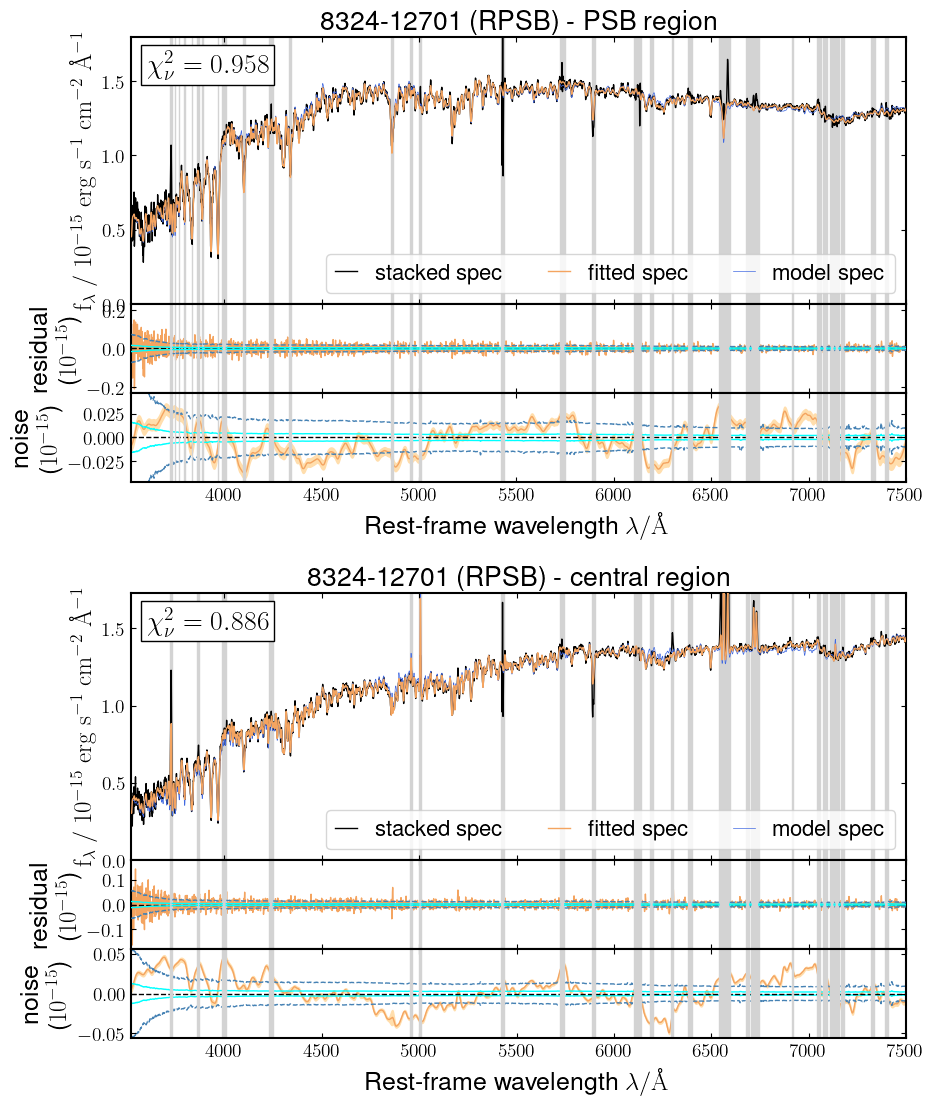

In [18]:
fig = plt.figure(figsize=[10,13])
gs = fig.add_gridspec(2, 1, wspace=0, hspace=0.25)

axes = plot_spec_paper_panel(fit_PSB, fit_obj_PSB, gs[0], N=500, rest_frame=True, y_scale=-15)
axes[0].set_title('8324-12701 (RPSB) - PSB region')
axes = plot_spec_paper_panel(fit_central, fit_obj_central, gs[1], N=500, rest_frame=True, y_scale=-15)
axes[0].set_title('8324-12701 (RPSB) - central region')

plt.show()

In [19]:
fig.savefig(save_dir+'RPSB_bothregion_fit_example.pdf', bbox_inches='tight', dpi=200)